In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import pickle
#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
path_extracted_data = config.path_extracted_data
id_run = config.id_run
path_extracted_data_adap = os.path.join(path_extracted_data,'Adaptability')
print(id_run)

ALLDATA_


# Download data

In [4]:
#data used in random regression model
df = pd.read_csv(os.path.join(path_extracted_data_adap,'df_MVT_4individuality_withPCA.csv'), sep=',')
print(df.shape)
display(df.head(3))

(3230, 26)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,nbr_stays_5_Zone_perh,nbr_stays_1_Zone_perh,in_WG_15mnAfterOpening,SleepingHeight,vertical_travel_distance_perh,DIB_startat11,avgDIB,severity,Feathers,PC1
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,0.1,0.0,0,3,0.0,0,22.357143,34,73.0,-1.738433
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,0.2,0.0,0,3,0.6,1,22.357143,34,73.0,-1.455477
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,0.1,0.0,0,3,0.0,2,22.357143,34,73.0,-1.738433


In [5]:
#download predictability estimates
df_pred = pd.read_csv(os.path.join(path_extracted_data_adap,'BLUPS_variability.csv'), sep=',')
print(df_pred.shape)
display(df_pred.head(3))
print(list(df_pred.columns))
#sd_HenID__sigma_Intercept: is the estimate for individual differences in residual variance
#b_sigma_Intercept: is the population level estimate of the residual variance
li_col = [x for x in df_pred.columns if 'r_HenID__sigma' in x]
df_pred = df_pred[li_col]
display(df_pred.head(3))
#melt data for simplicity
df_pred['run'] = df_pred.index
df_pred = pd.melt(df_pred, id_vars=['run'], value_vars=li_col)
df_pred['HenID'] = df_pred['variable'].map(lambda x: x.split('r_HenID__sigma.')[1].split('.')[0])
#"Importantly, in order to assess whether individuals differ in variance the residual part of the model iscalculated on the log 
#scale! In order to interpret rIIV in biological terms we backtransform rIIV by takingit’s original scale by taking its exponent"
df_pred['Variability'] = df_pred['value'].map(lambda x: np.exp(x))
df_pred['Predictability'] = df_pred['Variability'].map(lambda x: x*(-1))
print(df_pred.shape)
df_pred.head(3)

#predictability
df_pred_summarized = df_pred.groupby('HenID')['Predictability'].agg(lambda x: list(x)).reset_index()
df_pred_summarized['Predictability_mean'] = df_pred_summarized['Predictability'].map(lambda x: np.mean(x))
df_pred_summarized['Predictability_sd'] = df_pred_summarized['Predictability'].map(lambda x: np.std(x))
print(df_pred_summarized.shape)
df_pred_summarized.head(3)

(2500, 3360)


,X1.b_Intercept,X1.b_sigma_Intercept,X1.b_time,X1.b_time2,X1.b_avgDIB_scale,X1.b_TreatmentOFH,X1.b_temperature_C_avg_scale,X1.b_InitialWeight_scale,X1.sd_HenID__Intercept,X1.sd_HenID__time,...,X10.r_HenID__sigma.hen_85.Intercept.,X10.r_HenID__sigma.hen_87.Intercept.,X10.r_HenID__sigma.hen_9.Intercept.,X10.r_HenID__sigma.hen_90.Intercept.,X10.r_HenID__sigma.hen_92.Intercept.,X10.r_HenID__sigma.hen_95.Intercept.,X10.r_HenID__sigma.hen_97.Intercept.,X10.r_HenID__sigma.hen_98.Intercept.,X10.r_HenID__sigma.hen_99.Intercept.,X10.lp__
0,-0.640195,-0.742867,1.230092,-0.288283,-0.031986,-0.073525,-0.041974,-0.049468,1.274382,0.900977,...,0.229506,0.311681,-0.171672,0.080115,0.145154,-0.261876,-0.280026,-0.173894,-0.427452,-2656.222110
1,-0.501929,-0.683361,1.146991,-0.269622,-0.016731,-0.294469,-0.021345,-0.134765,1.142840,0.848645,...,-0.030993,0.317522,-0.394913,-0.238324,-0.037096,-0.178496,-0.463418,0.198700,-0.390881,-2669.692882
2,-0.397537,-0.723381,1.086801,-0.260291,0.053658,-0.461731,-0.023141,-0.090907,1.170243,0.873755,...,0.192075,0.404720,-0.531437,-0.112802,0.213384,-0.143584,-0.377060,0.109614,-0.215680,-2719.853506


['X1.b_Intercept', 'X1.b_sigma_Intercept', 'X1.b_time', 'X1.b_time2', 'X1.b_avgDIB_scale', 'X1.b_TreatmentOFH', 'X1.b_temperature_C_avg_scale', 'X1.b_InitialWeight_scale', 'X1.sd_HenID__Intercept', 'X1.sd_HenID__time', 'X1.sd_HenID__time2', 'X1.sd_HenID__sigma_Intercept', 'X1.cor_HenID__Intercept__time', 'X1.cor_HenID__Intercept__time2', 'X1.cor_HenID__time__time2', 'X1.r_HenID.hen_10.Intercept.', 'X1.r_HenID.hen_101.Intercept.', 'X1.r_HenID.hen_102.Intercept.', 'X1.r_HenID.hen_106.Intercept.', 'X1.r_HenID.hen_107.Intercept.', 'X1.r_HenID.hen_109.Intercept.', 'X1.r_HenID.hen_112.Intercept.', 'X1.r_HenID.hen_116.Intercept.', 'X1.r_HenID.hen_118.Intercept.', 'X1.r_HenID.hen_119.Intercept.', 'X1.r_HenID.hen_124.Intercept.', 'X1.r_HenID.hen_127.Intercept.', 'X1.r_HenID.hen_128.Intercept.', 'X1.r_HenID.hen_13.Intercept.', 'X1.r_HenID.hen_134.Intercept.', 'X1.r_HenID.hen_136.Intercept.', 'X1.r_HenID.hen_137.Intercept.', 'X1.r_HenID.hen_138.Intercept.', 'X1.r_HenID.hen_139.Intercept.', 'X1.r_

,X1.r_HenID__sigma.hen_10.Intercept.,X1.r_HenID__sigma.hen_101.Intercept.,X1.r_HenID__sigma.hen_102.Intercept.,X1.r_HenID__sigma.hen_106.Intercept.,X1.r_HenID__sigma.hen_107.Intercept.,X1.r_HenID__sigma.hen_109.Intercept.,X1.r_HenID__sigma.hen_112.Intercept.,X1.r_HenID__sigma.hen_116.Intercept.,X1.r_HenID__sigma.hen_118.Intercept.,X1.r_HenID__sigma.hen_119.Intercept.,...,X10.r_HenID__sigma.hen_84.Intercept.,X10.r_HenID__sigma.hen_85.Intercept.,X10.r_HenID__sigma.hen_87.Intercept.,X10.r_HenID__sigma.hen_9.Intercept.,X10.r_HenID__sigma.hen_90.Intercept.,X10.r_HenID__sigma.hen_92.Intercept.,X10.r_HenID__sigma.hen_95.Intercept.,X10.r_HenID__sigma.hen_97.Intercept.,X10.r_HenID__sigma.hen_98.Intercept.,X10.r_HenID__sigma.hen_99.Intercept.
0,0.072181,0.402286,-0.609717,0.213040,0.253685,0.594524,-0.080049,-0.243474,0.152991,0.289052,...,0.120362,0.229506,0.311681,-0.171672,0.080115,0.145154,-0.261876,-0.280026,-0.173894,-0.427452
1,-0.083970,-0.007333,-0.515376,0.280414,0.547433,0.441773,-0.090810,-0.179580,0.142086,0.131356,...,-0.118291,-0.030993,0.317522,-0.394913,-0.238324,-0.037096,-0.178496,-0.463418,0.198700,-0.390881
2,0.080924,0.471329,-0.683145,0.152481,0.385966,0.592105,0.040268,-0.131030,0.184550,0.177584,...,-0.024830,0.192075,0.404720,-0.531437,-0.112802,0.213384,-0.143584,-0.377060,0.109614,-0.215680


(2000000, 6)
(80, 4)


,HenID,Predictability,Predictability_mean,Predictability_sd
0,hen_10,"[-1.0748503408789045, -0.9194592206493791, -1....",-1.033901,0.111852
1,hen_101,"[-1.4952383578698778, -0.9926939481192623, -1....",-1.261477,0.144561
2,hen_102,"[-0.5435048946245898, -0.5972758174592125, -0....",-0.553207,0.070103


In [6]:
#MVT since begining: to add info on the first week
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))
df_MVT_ALL = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT_ALL.shape)
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['HenID'].isin(li_selected_hens)]
#restrict to the adaptability study timeframe
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['level']<=config.max_date_adaptability]
print(df_MVT_ALL.shape)
#make sure we have their mvt
df_MVT_ALL = df_MVT_ALL[~df_MVT_ALL['perc_duration_5_Zone'].isnull()]
print(df_MVT_ALL.shape)
df_MVT_ALL.head(3)

80
(42300, 63)
(3750, 63)
(3750, 63)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight
114,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,18.0,5_Zone,0.0,80.0,20.0,100.0,NaN,NaN,NaN,3
115,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,0.0,5_Zone,0.0,0.0,0.0,0.0,NaN,NaN,NaN,3
116,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-10-02,3,...,0.0,3_Zone,1.0,50.0,25.0,100.0,NaN,NaN,NaN,1


# Add nbr days within first three without mvt

In [7]:
m = df_MVT_ALL['DIB'].min()
print(m)
df_nomvt = df_MVT_ALL[df_MVT_ALL['DIB'].isin([m,m+1,m+2])].groupby('HenID')[['Total_number_zone']].agg(lambda x: list(x)).reset_index()
df_nomvt['nbr_daysnomvt_over_3days'] = df_nomvt['Total_number_zone'].agg(lambda x: sum([i==1 for i in x]))
print(df_nomvt.shape)
display(df_nomvt.head(3))
df_all = pd.merge(df, df_nomvt[['HenID','nbr_daysnomvt_over_3days']],  on='HenID', how='left')
print(df_all.shape)
df_all.head(3)

1
(80, 3)


,HenID,Total_number_zone,nbr_daysnomvt_over_3days
0,hen_10,"[4.0, 2.0, 1.0]",1
1,hen_101,"[2.0, 2.0, 3.0]",0
2,hen_102,"[4.0, 1.0, 1.0]",2


(3230, 27)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,nbr_stays_1_Zone_perh,in_WG_15mnAfterOpening,SleepingHeight,vertical_travel_distance_perh,DIB_startat11,avgDIB,severity,Feathers,PC1,nbr_daysnomvt_over_3days
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,0.0,0,3,0.0,0,22.357143,34,73.0,-1.738433,1
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,0.0,0,3,0.6,1,22.357143,34,73.0,-1.455477,1
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,0.0,0,3,0.0,2,22.357143,34,73.0,-1.738433,1


# Add predictability estimates

In [8]:
print(df_all.shape)
df_all = pd.merge(df_all, df_pred_summarized[['HenID','Predictability_mean','Predictability_sd']],  on='HenID', how='left')
print(df_all.shape)
df_all.head(5)

(3230, 27)
(3230, 29)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,SleepingHeight,vertical_travel_distance_perh,DIB_startat11,avgDIB,severity,Feathers,PC1,nbr_daysnomvt_over_3days,Predictability_mean,Predictability_sd
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,3,0.000000,0,22.357143,34,73.0,-1.738433,1,-0.859369,0.094129
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,3,0.600000,1,22.357143,34,73.0,-1.455477,1,-0.859369,0.094129
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,3,0.000000,2,22.357143,34,73.0,-1.738433,1,-0.859369,0.094129
3,hen_134,16,MEXP,pen10,7.833333,1,1112,TRAN,88,1,...,3,0.600000,5,22.357143,34,73.0,-1.476247,1,-0.859369,0.094129
4,hen_134,17,MEXP,pen10,10.500000,0,1112,TRAN,98,0,...,3,0.363636,6,22.357143,34,73.0,-1.644616,1,-0.859369,0.094129


In [9]:
df_all.to_csv(os.path.join(path_extracted_data_adap,'df_MVT_4stat_BI.csv'), index=False, sep=';')

# Visuals

In [10]:
print(df_all.shape)
df_all.head(3)

(3230, 29)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,SleepingHeight,vertical_travel_distance_perh,DIB_startat11,avgDIB,severity,Feathers,PC1,nbr_daysnomvt_over_3days,Predictability_mean,Predictability_sd
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,3,0.0,0,22.357143,34,73.0,-1.738433,1,-0.859369,0.094129
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,3,0.6,1,22.357143,34,73.0,-1.455477,1,-0.859369,0.094129
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,3,0.0,2,22.357143,34,73.0,-1.738433,1,-0.859369,0.094129


(80, 5)


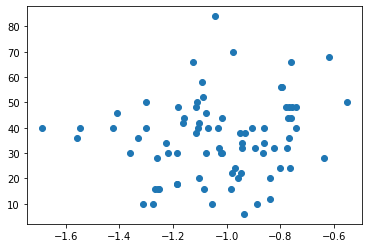

In [11]:
df_plt = df_all[['HenID','Predictability_mean','severity','Feathers','nbr_daysnomvt_over_3days']].drop_duplicates().copy()
print(df_plt.shape)
plt.scatter(df_plt['Predictability_mean'], df_plt['severity']);

C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


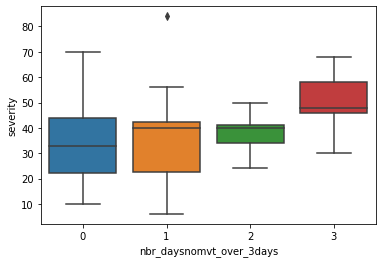

In [12]:
sns.boxplot('nbr_daysnomvt_over_3days','severity', data=df_plt);

In [13]:
df_plt['nbr_daysnomvt_over_3days'].value_counts()

0    52
1    16
2     7
3     5
Name: nbr_daysnomvt_over_3days, dtype: int64